In [85]:
import pandas as pd
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import sympy as smp
import re
from tqdm import tqdm
from scipy.linalg import svd
import scipy
from scipy.optimize import curve_fit 
import time
import os
from mat4py import loadmat
from sklearn.model_selection import train_test_split
import seaborn as sns

In [6]:
def avg(volt,curr,delta):
    V_avg,I_avg = [],[]
    for i in range(len(volt)):
        if i <delta:
            V_avg.append(volt[i])
            I_avg.append(curr[i])
        elif i>=delta:
            V_avg.append(np.mean(volt[i-delta:i])) 
            I_avg.append(np.mean(curr[i-delta:i]))
    return V_avg,I_avg

In [10]:
ExcelFiles = r''
data_LG = r''
if not os.path.isdir(ExcelFiles ):
    os.makedirs(ExcelFiles)

In [ ]:
temperature =  [0,10,-10,-20]
    # this list is used to name the sheets
for temp in tqdm(temperature):
    sheetnamelist = [] 
    excel_file = pd.ExcelWriter(r'\{}degC.xlsx'.format(temp))
    matfiledir = r'\{}degC\Drive cycles'.format(temp)
    fileslist = os.listdir(matfiledir)
    for matfiles in fileslist:
        matfilepath = os.path.join(matfiledir,matfiles)
        matdata = loadmat(matfilepath)['meas']
        voltage = [i[0] for i in matdata['Voltage']]
        current = [i[0] for i in matdata['Current']]
        Ah = [i[0] for i in matdata['Ah']]
        max_cap = np.max(np.abs(Ah))
        soc = list(map(lambda x: ((max_cap-x)/max_cap)*100,np.abs(Ah)))
        CellTemp = [i[0] for i in matdata['Battery_Temp_degC']]
        V_avg,I_avg = avg(voltage,current,399)                                     # data avg window size of 399 
        DictData = {'voltage':[],'current':[],'V_avg':[],'I_avg':[],'soc':[],'Temp':[]}
        DictData['voltage'] = voltage
        DictData['current'] = current
        DictData['soc'] = soc
        DictData['Temp'] = temp
        DictData['V_avg']= V_avg
        DictData['I_avg']= I_avg
        DictDataDf = pd.DataFrame(DictData)
        ExcelFilePath = os.path.join(ExcelFiles,'{}degCExcelFiles.xlsx'.format(temp))
        name = matfiles.split(' ')[-1].split('.')[0].split('_')[1]

        if name in sheetnamelist:
            sheetname = '{}_{}'.format(name,sheetnamelist.count(name))
            sheetnamelist.append(name)
        else:
            sheetname = name
            sheetnamelist.append(sheetname)
        DictDataDf.to_excel(excel_file, sheet_name=sheetname, index=False)
    excel_file.save()
    excel_file.close()

In [47]:
drivecycles = ['HWFET','US06','UDDS']
DriveCyclesData = {'voltage':[],'current':[],'V_avg':[],'I_avg':[],'soc':[],'Temp':[]}
for files in tqdm(os.listdir(ExcelFiles)):
    for cycle in drivecycles:
        ExcelData = pd.read_excel(r'\ExcelfilesPansonic\{}'.format(files),sheet_name = cycle)
        DriveCyclesData['voltage'].extend(ExcelData['voltage'])
        DriveCyclesData['current'].extend(ExcelData['current'])
        DriveCyclesData['V_avg'].extend(ExcelData['V_avg'])
        DriveCyclesData['I_avg'].extend(ExcelData['I_avg'])
        DriveCyclesData['soc'].extend(ExcelData['soc'])
        DriveCyclesData['Temp'].extend(ExcelData['Temp'])   
dfDriveCycleData = pd.DataFrame(DriveCyclesData)
dfDriveCycleData['Crate'] = list(map(lambda x: abs(x)/2.9 , dfDriveCycleData['current']))
X = dfDriveCycleData.drop(columns= ['soc'])
Y = dfDriveCycleData['soc'].values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:38<00:00, 39.68s/it]


In [48]:
# Check Any null values, if any null values are present we have to impute with mean values
print(dfDriveCycleData.isna().any().values)
print(dfDriveCycleData.isnull().any().values)

[False False False False False False False]
[False False False False False False False]


In [57]:
dfCrate01,dfCrate12,dfCrate23,dfCrate34,dfCrate47 = {},{},{},{},{}
Temp_train = {}
for i in temperature: 
    dfCrate01['{}_degC'.format(i)]=X_train[(X_train['Temp']==i)&(X_train['Crate']>0)&(X_train['Crate']<1)].count().values[0]
    dfCrate12['{}_degC'.format(i)]=X_train[(X_train['Temp']==i)&(X_train['Crate']>1)&(X_train['Crate']<2)].count().values[0]
    dfCrate23['{}_degC'.format(i)]=X_train[(X_train['Temp']==i)&(X_train['Crate']>2)&(X_train['Crate']<3)].count().values[0]
    dfCrate34['{}_degC'.format(i)]=X_train[(X_train['Temp']==i)&(X_train['Crate']>3)&(X_train['Crate']<4)].count().values[0]
    dfCrate47['{}_degC'.format(i)]=X_train[(X_train['Temp']==i)&(X_train['Crate']>4)&(X_train['Crate']<7)].count().values[0]
    Temp_train['{}_degC'.format(i)]= X_train[(X_train['Temp']==i)].count().values[0]  

In [59]:
br1 = np.arange(len(dfCrate01.keys()))
width_bar = 0.25
br2 = [x +width_bar for x in br1]
br3= [x +width_bar for x in br2]
br4= [x +width_bar for x in br3]
br5= [x +width_bar for x in br4]

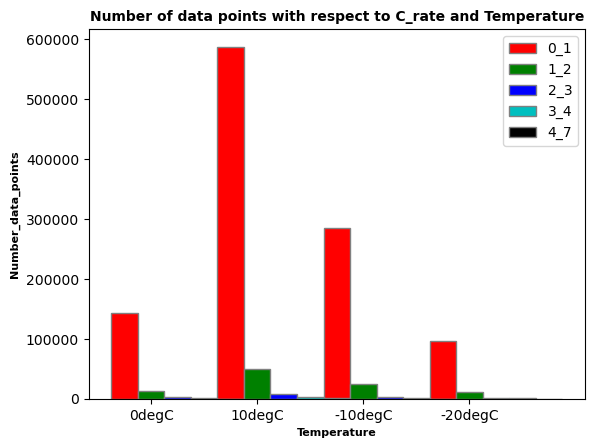

In [62]:
plt.bar(br1, list(dfCrate01.values()), color ='r', width = width_bar,edgecolor ='grey', label ='0_1')
plt.bar(br2, list(dfCrate12.values()), color ='g', width = width_bar,edgecolor ='grey', label ='1_2')
plt.bar(br3, list(dfCrate23.values()), color ='b', width = width_bar,edgecolor ='grey', label ='2_3')
plt.bar(br4, list(dfCrate34.values()), color ='c', width = width_bar,edgecolor ='grey', label ='3_4')
plt.bar(br5, list(dfCrate47.values()), color ='black', width = width_bar,edgecolor ='grey', label ='4_7')
plt.xlabel('Temperature',fontweight='bold',fontsize= 8)
plt.ylabel('Number_data_points',fontweight='bold',fontsize= 8)
plt.xticks([i+width_bar for i in range(len(dfCrate01.keys()))],['0degC','10degC','-10degC','-20degC'])
plt.title('Number of data points with respect to C_rate and Temperature',fontweight='bold',fontsize= 10)
plt.legend()
#path_image = os.path.join(Dl_sub_dir,'Total_Data_points.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

In [63]:
testdfCrate01,testdfCrate12,testdfCrate23,testdfCrate34,testdfCrate47 = {},{},{},{},{}
Temp_test = {}
for i in temperature: 
    testdfCrate01['{}_degC'.format(i)]=X_test[(X_test['Temp']==i)&(X_test['Crate']>0)&(X_test['Crate']<1)].count().values[0]
    testdfCrate12['{}_degC'.format(i)]=X_test[(X_test['Temp']==i)&(X_test['Crate']>1)&(X_test['Crate']<2)].count().values[0]
    testdfCrate23['{}_degC'.format(i)]=X_test[(X_test['Temp']==i)&(X_test['Crate']>2)&(X_test['Crate']<3)].count().values[0]
    testdfCrate34['{}_degC'.format(i)]=X_test[(X_test['Temp']==i)&(X_test['Crate']>3)&(X_test['Crate']<4)].count().values[0]
    testdfCrate47['{}_degC'.format(i)]=X_test[(X_test['Temp']==i)&(X_test['Crate']>4)&(X_test['Crate']<7)].count().values[0]
    Temp_test['{}_degC'.format(i)]= X_test[(X_test['Temp']==i)].count().values[0]  

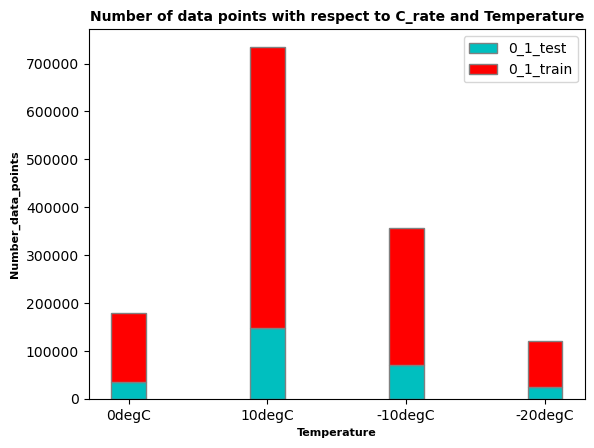

In [73]:
plt.bar(br1, list(testdfCrate01.values()), color ='c', width = width_bar,edgecolor ='grey', label ='0_1_test')
plt.bar(br1, list(dfCrate01.values()), bottom=list(testdfCrate01.values()) ,color ='r', width = width_bar,edgecolor ='grey', label ='0_1_train')
plt.xlabel('Temperature',fontweight='bold',fontsize= 8)
plt.ylabel('Number_data_points',fontweight='bold',fontsize= 8)
plt.xticks([i for i in range(len(testdfCrate01.keys()))],['0degC','10degC','-10degC','-20degC'])
plt.title('Number of data points with respect to C_rate and Temperature',fontweight='bold',fontsize= 10)
plt.legend()
#path_image = os.path.join(Dl_sub_dir,'Data_0_1_Crate_wrt_temp.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

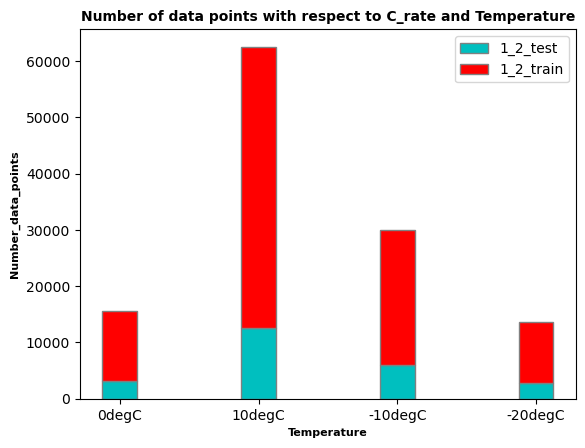

In [74]:
plt.bar(br1, list(testdfCrate12.values()), color ='c', width = width_bar,edgecolor ='grey', label ='1_2_test')
plt.bar(br1, list(dfCrate12.values()), bottom=list(testdfCrate12.values()) ,color ='r', width = width_bar,edgecolor ='grey', label ='1_2_train')
plt.xlabel('Temperature',fontweight='bold',fontsize= 8)
plt.ylabel('Number_data_points',fontweight='bold',fontsize= 8)
plt.xticks([i for i in range(len(testdfCrate01.keys()))],['0degC','10degC','-10degC','-20degC'])
plt.title('Number of data points with respect to C_rate and Temperature',fontweight='bold',fontsize= 10)
plt.legend()
#path_image = os.path.join(Dl_sub_dir,'Data_0_1_Crate_wrt_temp.png')

#plt.savefig(path_image,dpi= 150)
plt.show()

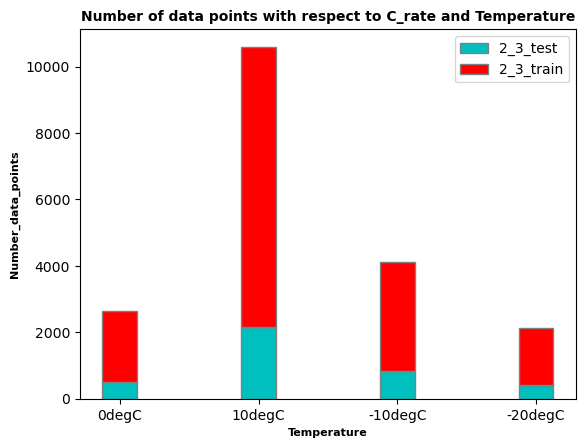

In [68]:
plt.bar(br1, list(testdfCrate23.values()), color ='c', width = width_bar,edgecolor ='grey', label ='2_3_test')
plt.bar(br1, list(dfCrate23.values()), bottom=list(testdfCrate23.values()) ,color ='r', width = width_bar,edgecolor ='grey', label ='2_3_train')
plt.xlabel('Temperature',fontweight='bold',fontsize= 8)
plt.ylabel('Number_data_points',fontweight='bold',fontsize= 8)
plt.xticks([i for i in range(len(testdfCrate01.keys()))],['0degC','10degC','-10degC','-20degC'])
plt.title('Number of data points with respect to C_rate and Temperature',fontweight='bold',fontsize= 10)
plt.legend()
#path_image = os.path.join(Dl_sub_dir,'Data_0_1_Crate_wrt_temp.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

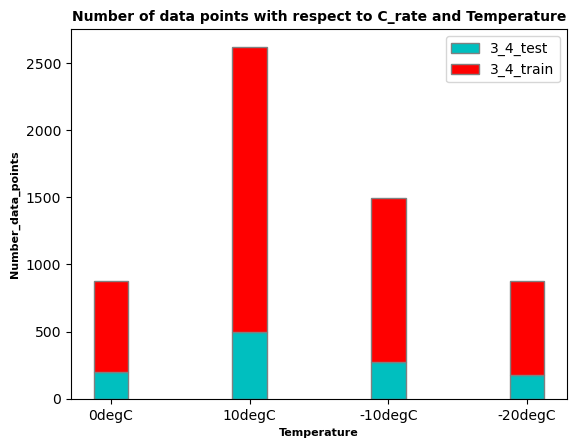

In [69]:
plt.bar(br1, list(testdfCrate34.values()), color ='c', width = width_bar,edgecolor ='grey', label ='3_4_test')
plt.bar(br1, list(dfCrate34.values()), bottom=list(testdfCrate34.values()) ,color ='r', width = width_bar,edgecolor ='grey', label ='3_4_train')
plt.xlabel('Temperature',fontweight='bold',fontsize= 8)
plt.ylabel('Number_data_points',fontweight='bold',fontsize= 8)
plt.xticks([i for i in range(len(testdfCrate01.keys()))],['0degC','10degC','-10degC','-20degC'])
plt.title('Number of data points with respect to C_rate and Temperature',fontweight='bold',fontsize= 10)
plt.legend()
#path_image = os.path.join(Dl_sub_dir,'Data_0_1_Crate_wrt_temp.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

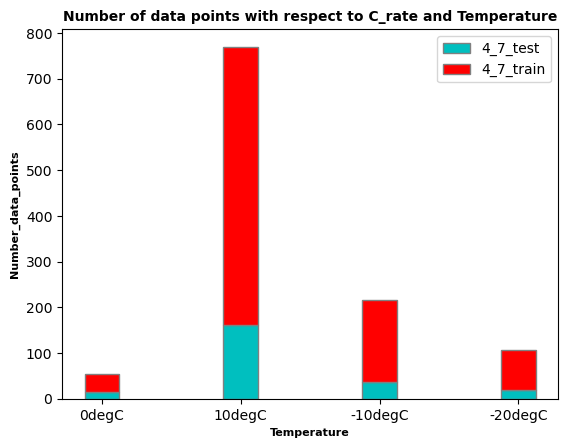

In [70]:
plt.bar(br1, list(testdfCrate47.values()), color ='c', width = width_bar,edgecolor ='grey', label ='4_7_test')
plt.bar(br1, list(dfCrate47.values()), bottom=list(testdfCrate47.values()) ,color ='r', width = width_bar,edgecolor ='grey', label ='4_7_train')
plt.xlabel('Temperature',fontweight='bold',fontsize= 8)
plt.ylabel('Number_data_points',fontweight='bold',fontsize= 8)
plt.xticks([i for i in range(len(testdfCrate01.keys()))],['0degC','10degC','-10degC','-20degC'])
plt.title('Number of data points with respect to C_rate and Temperature',fontweight='bold',fontsize= 10)
plt.legend()
#path_image = os.path.join(Dl_sub_dir,'Data_0_1_Crate_wrt_temp.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

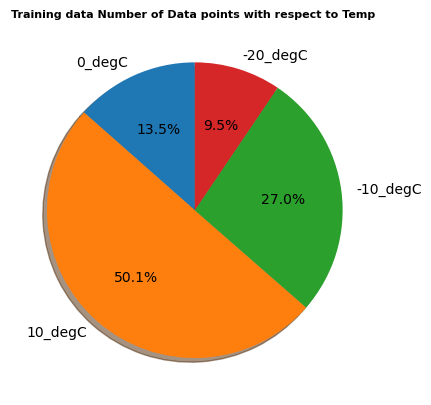

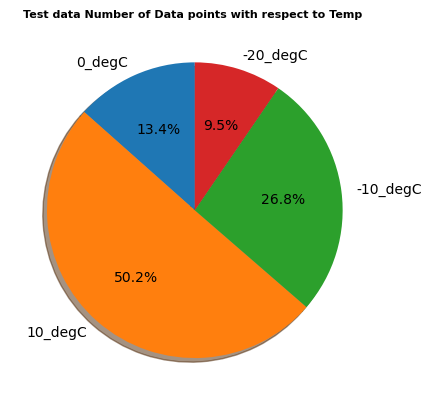

In [77]:
labels = list(Temp_train.keys())
Train_count = list(Temp_train.values())
fig1,ax1 = plt.subplots() 
ax1.pie(Train_count, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Training data Number of Data points with respect to Temp ',fontweight='bold',fontsize= 8)
#path_image = os.path.join(Dl_sub_dir,'Train_Total_Data_pie_chart.png')
#plt.savefig(path_image,dpi= 150)
plt.show()
Test_count = list(Temp_test.values())
fig1,ax1 = plt.subplots() 
ax1.pie(Test_count, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Test data Number of Data points with respect to Temp ',fontweight='bold',fontsize= 8)
#path_image = os.path.join(Dl_sub_dir,'Test_Total_Data_pie_chart.png')
#plt.savefig(path_image,dpi= 150)
plt.show()


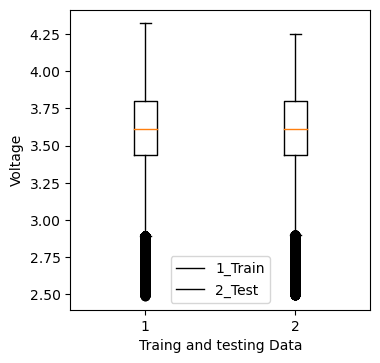

In [81]:
fig = plt.figure(figsize =(3,3))
ax = fig.add_axes([0, 0, 1, 1])
data = [X_train['voltage'].values,X_test['voltage'].values]
bp = ax.boxplot(data)
plt.xlabel('Traing and testing Data')
plt.ylabel('Voltage')
plt.legend(['1_Train','2_Test'])
#path_image = os.path.join(Dl_sub_dir,'Voltage_Box.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

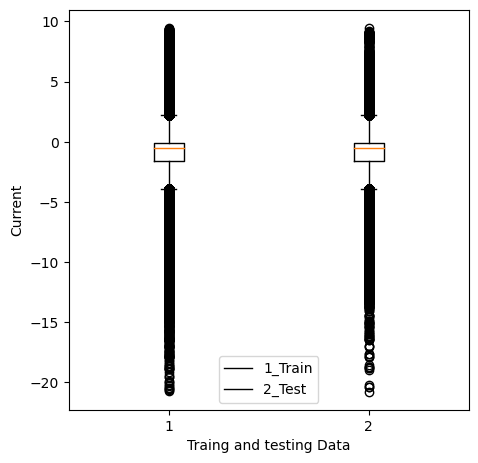

In [83]:
fig = plt.figure(figsize =(4, 4))
ax = fig.add_axes([0, 0, 1, 1])
data = [X_train['current'].values,X_test['current'].values]
bp = ax.boxplot(data)
plt.xlabel('Traing and testing Data')
plt.ylabel('Current')
plt.legend(['1_Train','2_Test'])
#path_image = os.path.join(Dl_sub_dir,'Current_Box.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

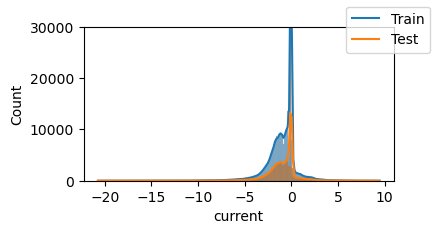

In [86]:
fig = plt.figure(figsize=(4,2))
sns.histplot(data=X_train,x = 'current' ,kde=True)
plt.ylim([0,30000])
sns.histplot(data=X_test,x = 'current' ,kde=True)
fig.legend(labels =['Train','Test'])
#path_image = os.path.join(Dl_sub_dir,'Train_Test_sns_dist_curr.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

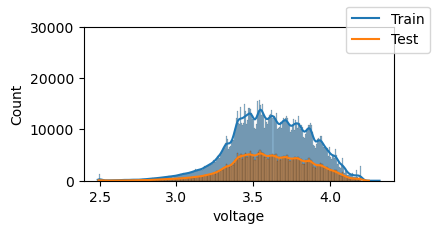

In [87]:
fig = plt.figure(figsize=(4,2))
sns.histplot(data=X_train,x = 'voltage' ,kde=True)
plt.ylim([0,30000])
sns.histplot(data=X_test,x = 'voltage' ,kde=True)
fig.legend(labels =['Train','Test'])
#path_image = os.path.join(Dl_sub_dir,'Train_Test_sns_dist_curr.png')
#plt.savefig(path_image,dpi= 150)
plt.show()

Text(0.5, 0, 'Current')

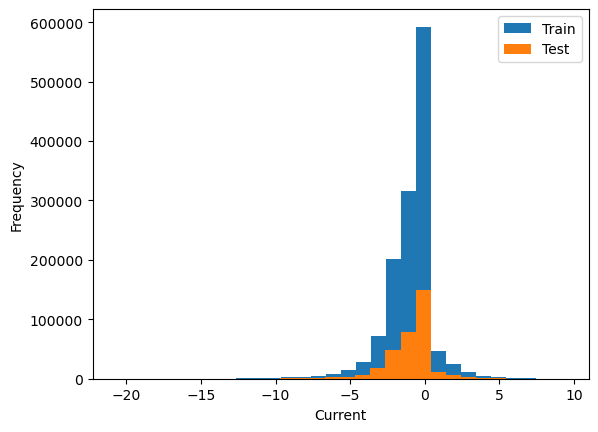

In [88]:
X_train['current'].plot.hist(bins=30)
X_test['current'].plot.hist(bins=30)
plt.legend(['Train','Test'])
plt.xlabel('Current')

Text(0.5, 0, 'Voltage')

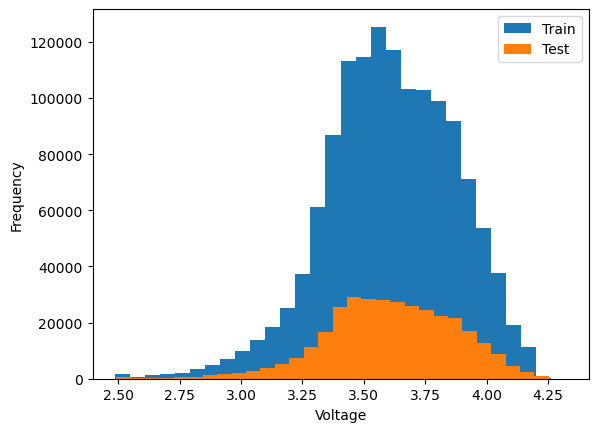

In [89]:
X_train['voltage'].plot.hist(bins=30)
X_test['voltage'].plot.hist(bins=30)
plt.legend(['Train','Test'])
plt.xlabel('Voltage')

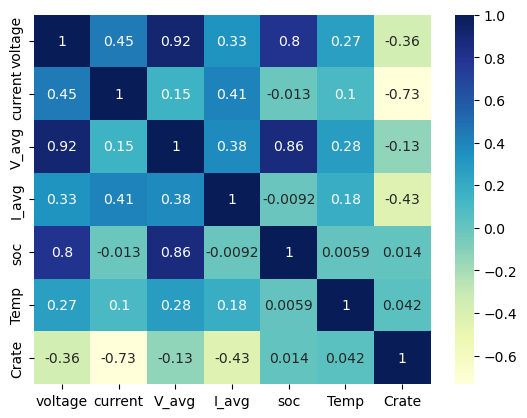

In [91]:
#data_df = data_df[['voltage','current','V_avg','I_avg','Temp','soc']]
dataplot = sns.heatmap(dfDriveCycleData.corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()